In [1]:
#### 2 . Import the required libraries
import re
import spacy
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
# Load your dataset
df = pd.read_excel("/Users/prathamesh/downloads/twitter (1).xlsx")
df.drop(columns='Unnamed: 0', inplace=True)
df.dropna(inplace=True)


In [3]:
#### 1. Understand the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


In [4]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
##### 3. Preprocess the data
#using spacy for text processing
nlp = spacy.load("en_core_web_sm")

# preprocessing function
def preprocess_tweet(tweet):
    tweet = re.sub(r'\bRT\b', '', tweet)  # Remove RT indicating retweets
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'[@#]\S+', '', tweet)  # Remove mentions and hashtags
    tweet = re.sub(r'[^A-Za-z0-9 ]+', '', tweet)  # Remove special characters
    tweet = tweet.lower()  # Convert to lower case
    
    # process  with spaCy
    doc = nlp(tweet)
    
    # remove stopwords and lemmatize
    clean_tweet = ' '.join([token.lemma_ for token in doc if not token.is_stop])
    return clean_tweet



In [ ]:
# Applying  preprocessing to tweets
df['tweet'] = df['tweet'].apply(preprocess_tweet)

In [42]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,woman not complain clean house amp man trash
1,3,0,3,0,1,boy dat coldtyga dwn bad cuffin dat hoe 1s...
2,3,0,3,0,1,dawg fuck bitch start cry confuse shit
3,3,0,2,1,1,look like tranny
4,6,0,6,0,1,shit hear true faker bitch tell ya


In [10]:
# prepare labels
X = df['tweet']
y = df['class']

In [43]:
####### 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [44]:
# Use a pipeline to vectorize and train the model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)
print(f"Model training completed.")


Model training completed.


In [45]:
# Evaluate the model
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['hate_speech', 'offensive_language', 'No offense no Hate']))


                    precision    recall  f1-score   support

       hate_speech       0.53      0.13      0.21       164
offensive_language       0.91      0.96      0.93      1905
No offense no Hate       0.81      0.88      0.85       410

          accuracy                           0.89      2479
         macro avg       0.75      0.66      0.66      2479
      weighted avg       0.87      0.89      0.87      2479



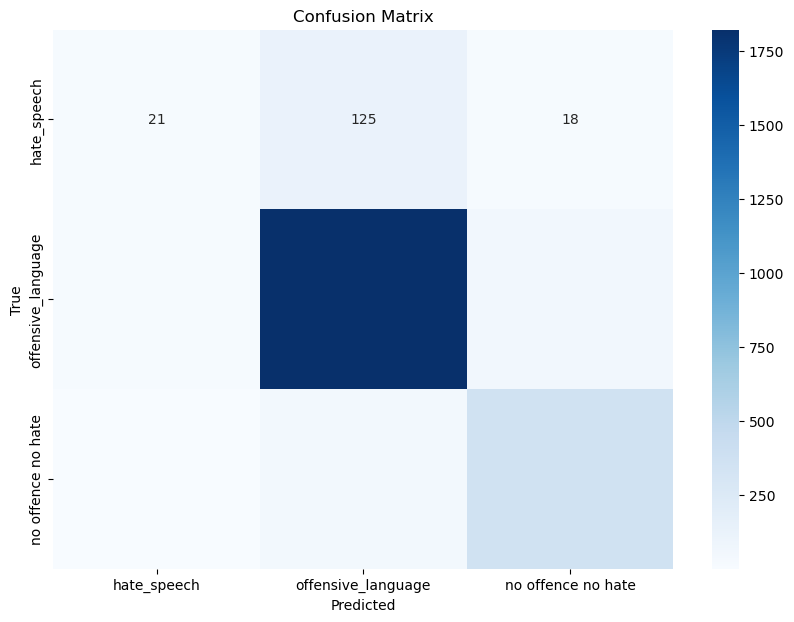

In [46]:
# Compute confusion matrix
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display_labels = ['hate_speech', 'offensive_language', 'no offence no hate']

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_display_labels, yticklabels=cm_display_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

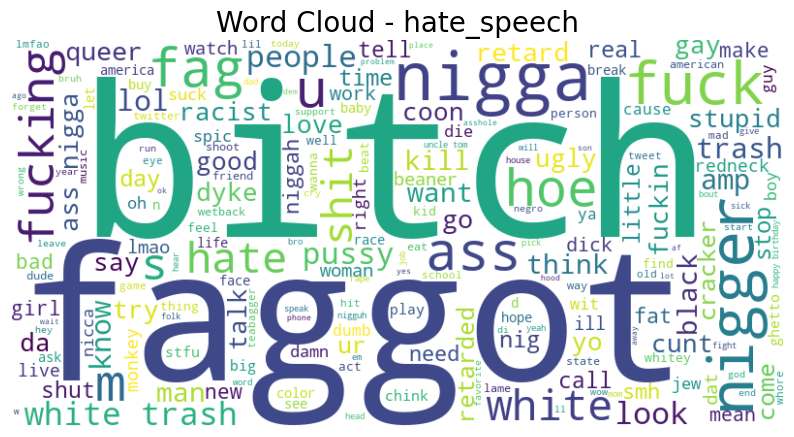

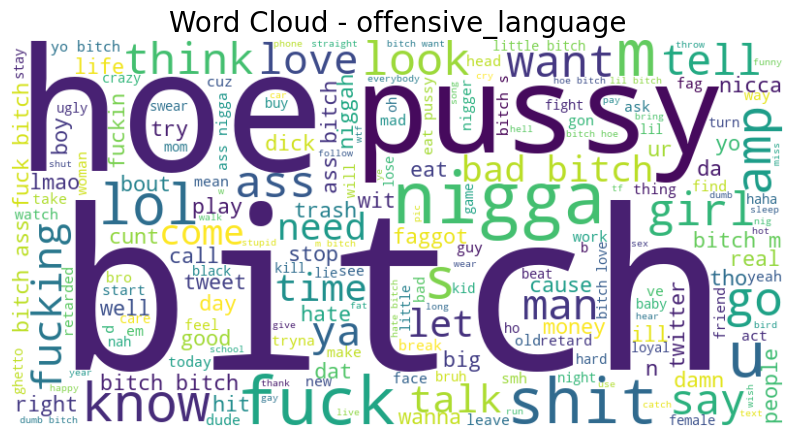

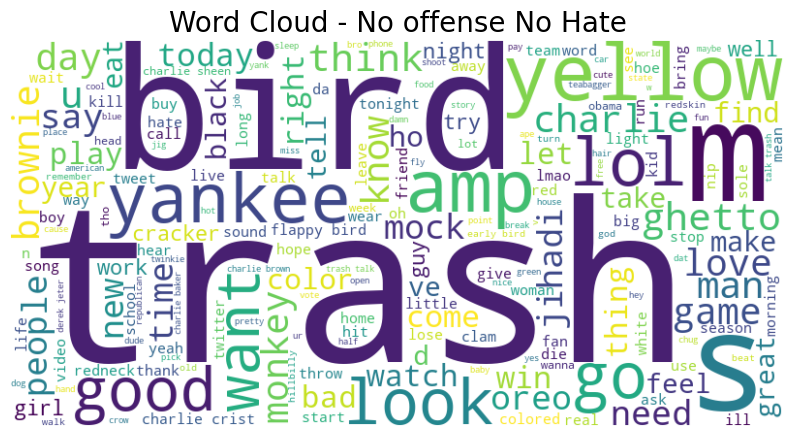

In [47]:
##### word cloud of all tweets
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, random_state=42, background_color='white').generate(text)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, size=20)
    plt.axis('off')
    plt.show()


for class_label, class_name in enumerate(['hate_speech', 'offensive_language', 'No offense No Hate']):
    class_text = " ".join(df[df['class'] == class_label]['tweet'].tolist())
    generate_wordcloud(class_text, f'Word Cloud - {class_name}')


In [ ]:
# Function to map prediction to label
def map_prediction_to_label(pred):
    label_map = {
        0: "hate_speech",
        1: "offensive_language",
        2: "No Hate No Offence"
    }
    return label_map.get(pred, "Unknown")

# Interactive part to get user input and predict
while True:
    user_input = input("Enter a Text: ")
    if not user_input:
        print("Empty input. Exiting.")
        break
    
    user_input_preprocessed = preprocess_tweet(user_input)
    prediction = pipeline.predict([user_input_preprocessed])
    label = map_prediction_to_label(prediction[0])
    print(f"Prediction: ['{label}']")


Enter a Text:  hello


Prediction: ['No Hate No Offence']


Enter a Text:  Good morning


Prediction: ['No Hate No Offence']


Enter a Text:  nigga


Prediction: ['offensive_language']
